# Первичная обработка основных признаков и обучение на наих Ridge-регрессии со стандартными параметрами. (Закончила)

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

sns.set(style="darkgrid")

In [178]:
data = pd.read_csv("data.csv", encoding='latin1')

Цели для обработки данных:

*   Remove features associated with >85% missing values
*   Remove constant features
*   Remove duplicates features
*   Remove duplicate rows
*   Remove highly collinear features

# Вспомагательные функции для графиков:



In [179]:
# https://towardsdatascience.com/financial-data-analysis-bf4b5e78c45c
# Эта функция строит графики с учетом того, категориальный ли признак

def plot_feature(col_name, isContinuous, df): 
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

# Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Loan Status')
    else:
        data = df.groupby(col_name)['loan_status'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= "loan_status", data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    plt.show()

# **Описание данных:**

**loan_amnt** - запрашиваемая у банка сумма для кредита \

**funded_amnt** - накопительная сумма \

**funded_amnt_inv** - накопительная сумма для инвестора \

**term** - на какой промежуток выдан кредит

**int_rate** - процентная ставка \

**installment** - первоначальный взнос \

**grade** - оценка кредитного риска

**emp_title** - профессия

**emp_length** - опыт работы

**home_ownership** - тип жилья

**annual_inc** - годовые доходы \

**verification_status** - статус верификации

**issue_d** - месяц в который получено финансирование

**purpose** - цель

**addr_state** - кто выдает кредит (гос сторона)

**dti** - это процент ежемесячного валового дохода потребителя, который идет на выплату долгов \

**delinq_2yrs** - просрочка платежей более чем на 30 дней за последние два года \

**earliest_cr_line** - месяц открытия самой ранней кредитной истории

**inq_last_6mths** - количество обращений кредитора(то есть Банка) в бюро кредитных историй, если клиент ходит по разным банкам и просит кредиты, то это говорит, что этому клиенту либо отказывают, либо он решил набрать везде кредитов. Как правило это негативно влияет \

**open_acc** - это количество открытых кредитов

**revol_bal** - общий оборотный остаток

**revol_util** - доля утилизации. Клиенту выдали кредитную карту с лимитом 100 рублей, он уже потратил 40 рублей, revol_util будет равен 40/100 = 0.4

**total_acc** - видимо все кредиты и активные, и закрытые

**out_prncp** - оставшаяся непогашенная сумма

**total_pymnt** - полученные на сегодня платежи

**loan_status** - текущий статус кредита (закрыт не закрыт)

**risk** - выадем не выдаем

# Обработка данных

In [180]:
data.drop_duplicates(inplace= True) # Сразу удалим все дубликаты

Посмотрим на пропущенные данные:

In [181]:
data.isna().sum()

id                         0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_title              29565
emp_length             22615
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                      148
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             1
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util               213
total_acc                  0
out_prncp                  0
total_pymnt                0
loan_status                0
risk                       0
dtype: int64

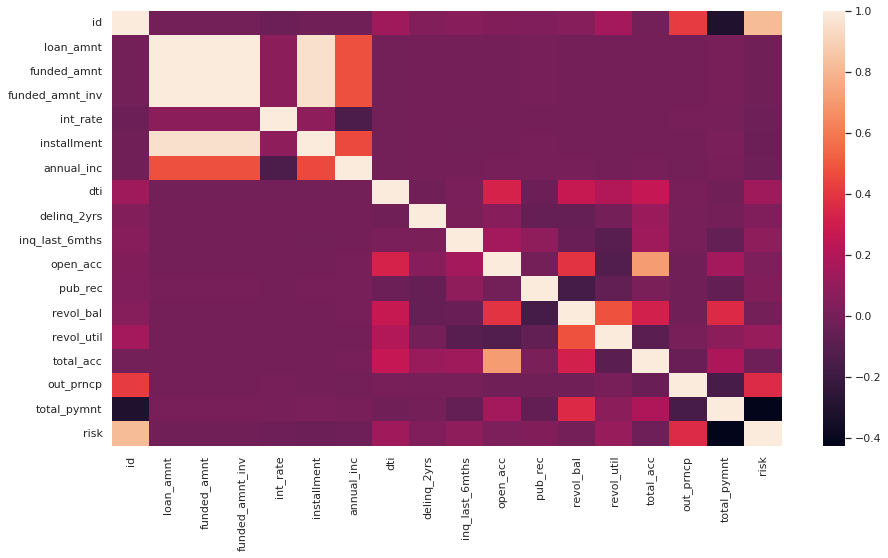

In [182]:
corr_matrix = data.corr(method = 'spearman')
# Я посмотрела разные methods но они все в принципе одинаковые

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

### risk

In [183]:
data['risk'].value_counts()

0    207036
1    103668
Name: risk, dtype: int64

Важно было убедиться, что у нас достаточное количество дефолтов для исследования и разница между признаками не превышает 70%.

### loan_amnt

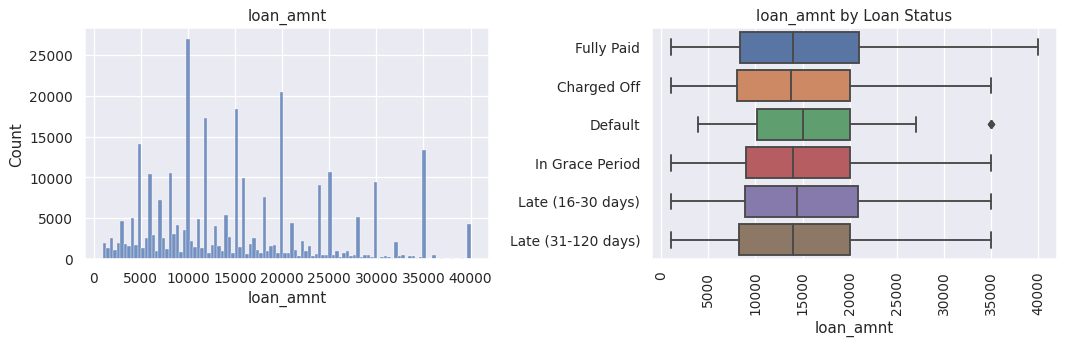

In [184]:
plot_feature('loan_amnt', True, data)

Сложно тут оценивать выбросы, потому что в принципе сумма займа не должна сильно зависеть от вероятности дефолта, поэтому пока оставлю так. Возможно, в будущем для рассмотрения стоит оставить только Fully Paid и Charged Off.

In [185]:
data = data.loc[(data['loan_status'].isin(['Fully Paid', 'Charged Off']))]

### annual_inc

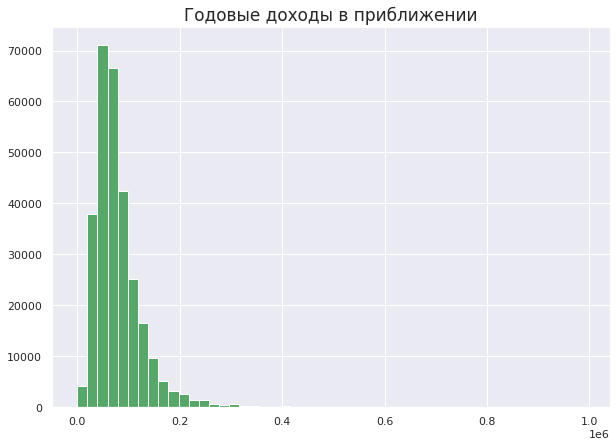

In [186]:
data[data['annual_inc'] < 1000000]['annual_inc'].hist(bins=50, figsize=(10, 7), color='g')

plt.title('Годовые доходы в приближении', size = 17)
plt.show()

### int_rate

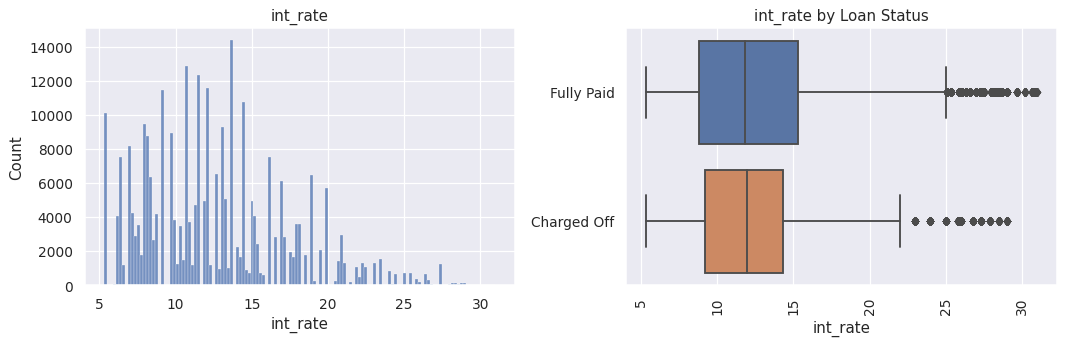

In [187]:
plot_feature('int_rate', True, data)

### installment

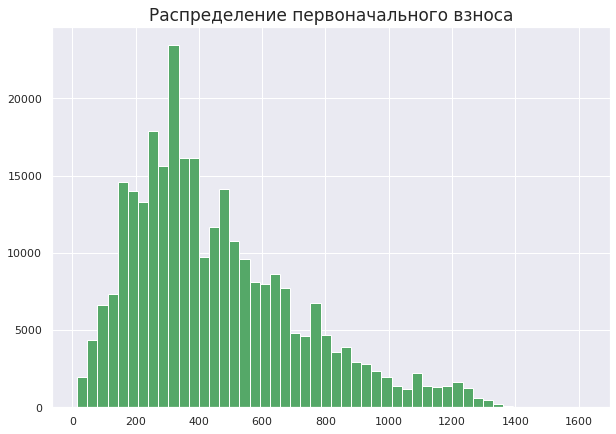

In [188]:
data['installment'].hist(color = 'g', bins=50, figsize=(10, 7))

plt.title('Распределение первоначального взноса', size = 17)
plt.show()

### funded_amnt и funded_amnt_inv

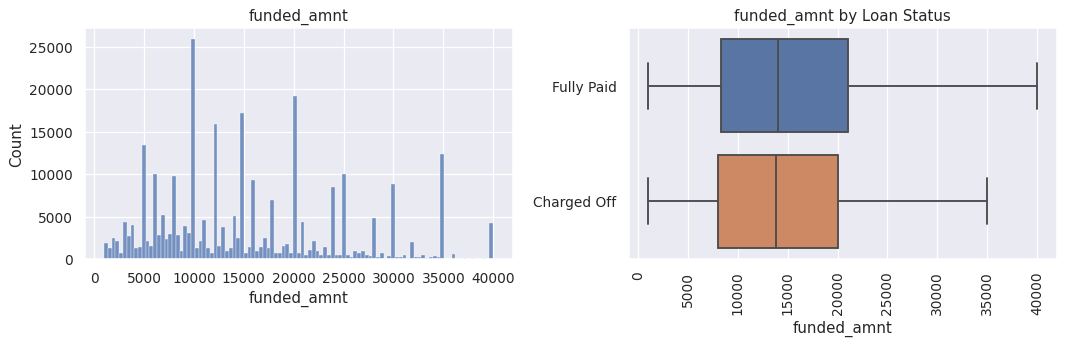

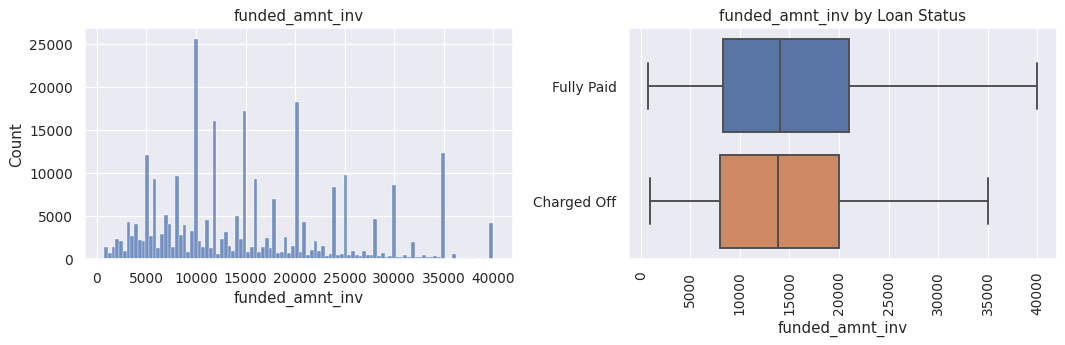

In [189]:
plot_feature('funded_amnt', True, data)
plot_feature('funded_amnt_inv', True, data)

Не уверена, нужны ли нам два настолько близких признака. Я бы оставила только funded_amnt, потому что по ощущениям данные там чуть более полные.

In [190]:
data.drop('funded_amnt_inv', axis=1,  inplace=True) 

### pub_rec

In [191]:
data.drop('pub_rec', axis=1, inplace=True) 
# не поняли что это за признак

### emp_title

In [192]:
data['emp_title'].value_counts()

Teacher                         5309
Manager                         4609
Owner                           2539
Registered Nurse                2261
Driver                          2032
                                ... 
Lineman/Troubleman                 1
Senior SEC Reporting Analyst       1
surgery scheduler                  1
PBX Operator,V.A.                  1
Economist                          1
Name: emp_title, Length: 86769, dtype: int64

Слишком много уникальных профессий и вероятнее всего они не отражают ничего дельного, поэтому этот признак можно удалить.

In [193]:
data.drop('emp_title', axis=1, inplace=True) 

### home_ownership

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


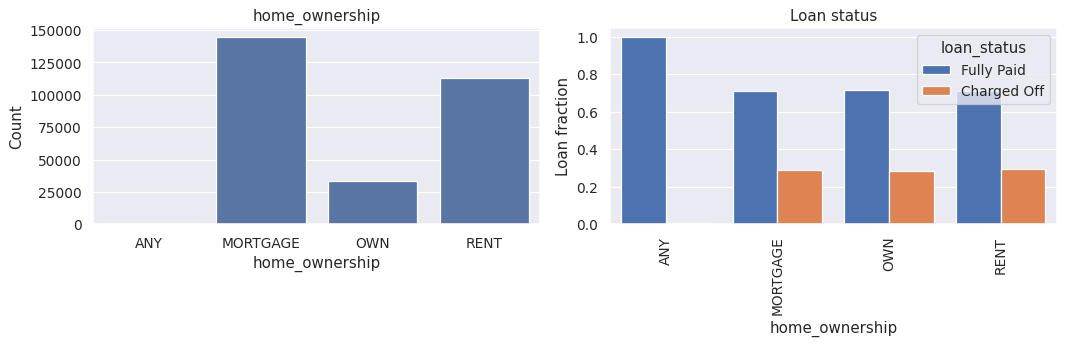

In [194]:
plot_feature('home_ownership', False, data)

Возможно на категориальных данных, которых сравнительно меньше остальных, модель будет сильно переобучаться, поэтому я думаю удалю "ANY"

In [195]:
data = data.drop(np.where(data['home_ownership'] == "ANY")[0])

KeyError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


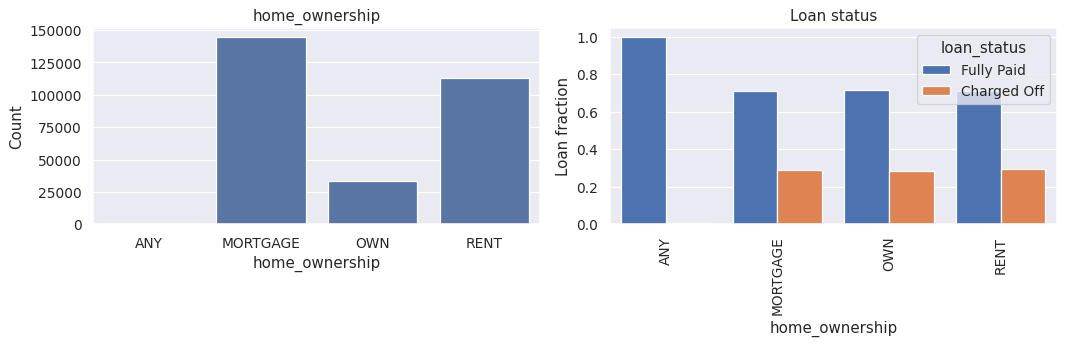

In [196]:
plot_feature('home_ownership', False, data)

### emp_length

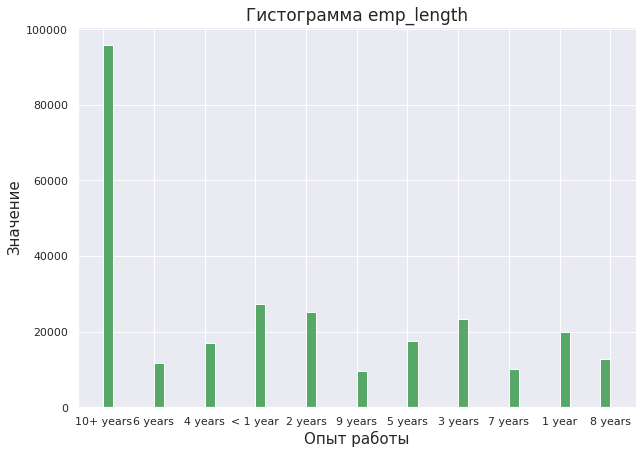

In [197]:
plt.ticklabel_format(style='plain')
data['emp_length'].hist(bins=50, facecolor='g', figsize=(10, 7))

plt.title('Гистограмма emp_length', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Так как меньше 10% признаков в emp_title и  emp_lenght пропущены, не будем выкидывать эти признаки, а просто заменим значения пустой строкой.

In [198]:
data.fillna(value={'emp_title': ''}, inplace = True)

Ниже с **emp_length** надо подумать, может лучше сделать просто количество лет и не делать это категориальным признаком

In [199]:
data['emp_length'].unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

In [200]:
data.fillna(value={'emp_length': 'No'}, inplace = True)

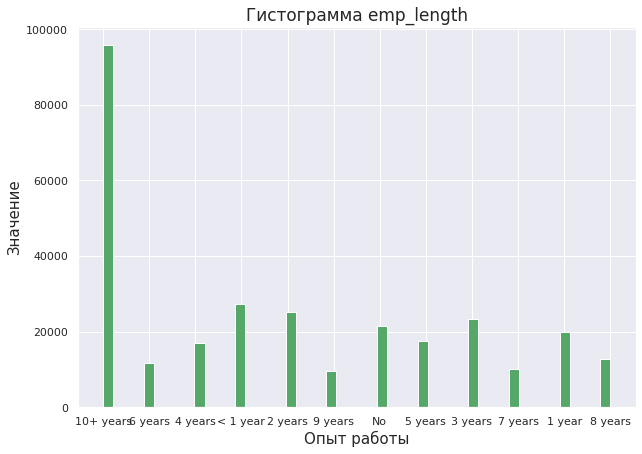

In [201]:
plt.ticklabel_format(style='plain')
data['emp_length'].hist(bins=50, facecolor='g', figsize=(10, 7))

plt.title('Гистограмма emp_length', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

### dti

Мне кажется один из важнейших признаков который должен очень сильно коррелировать - это процент с дохода, который идет на выплату. Очень красивое распределение

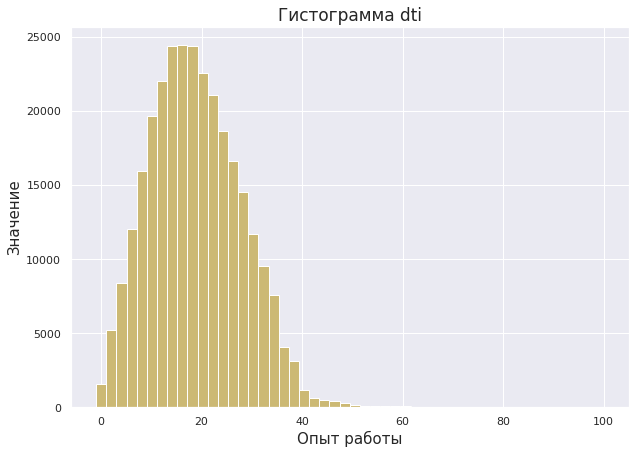

In [202]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

In [203]:
data.fillna(value={'dti': 0, 'revol_util': 0}, inplace = True)

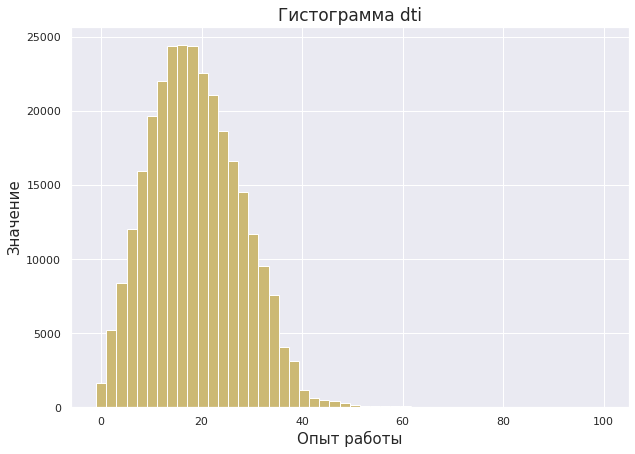

In [204]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Заполнение нулями ничего сильно не повредило, поэтому супер.

### grade

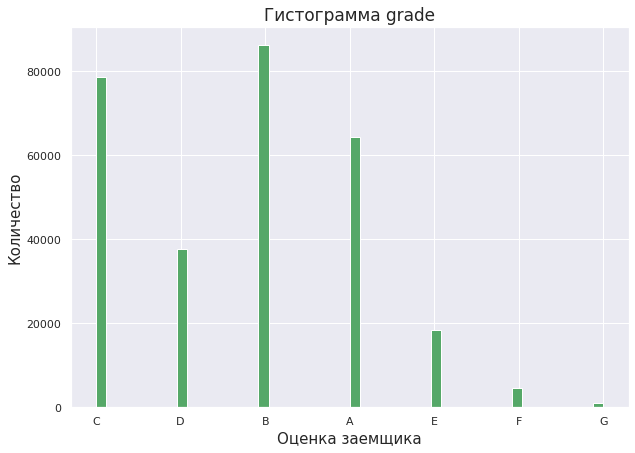

In [205]:
plt.ticklabel_format(style='plain')
data['grade'].hist(bins=50, color='g', figsize=(10, 7))

plt.title('Гистограмма grade', size = 17)
plt.xlabel('Оценка заемщика', size = 15)
plt.ylabel('Количество', size = 15)
plt.show()

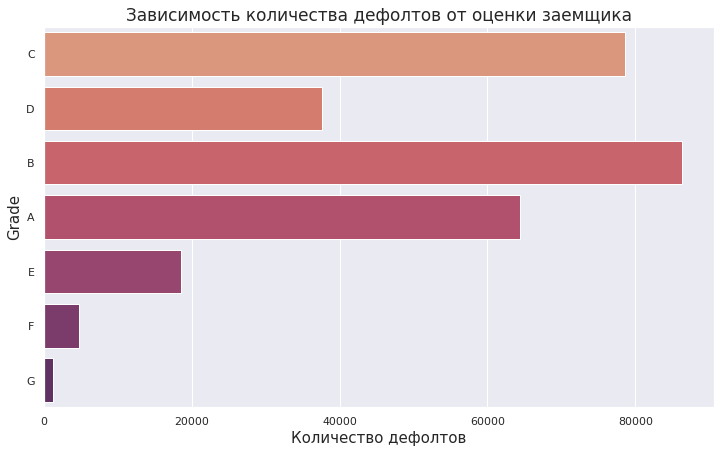

In [206]:
plt.figure(figsize=(12, 7))
sns.countplot(data = data, y = data['grade'], palette="flare")

plt.title('Зависимость количества дефолтов от оценки заемщика', size = 17)
plt.xlabel('Количество дефолтов', size = 15)
plt.ylabel('Grade', size = 15)
plt.show()

## Обучаемся на том что получилось

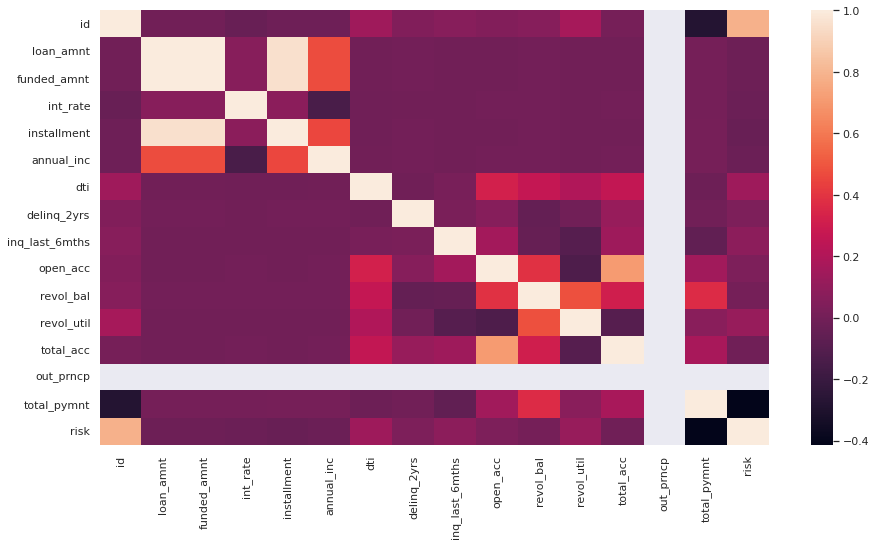

In [207]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8), )
sns.heatmap(corr_matrix.T)

plt.show()

После обработки не особо изменилась корреляция, но попробуем обучиться на половине признаков которые мы уже рассмотрели и посмотреть что будет.

In [209]:
categorical = ['term', 'grade', 'emp_length', 'home_ownership']
numeric_features = ['loan_amnt', 'int_rate', 'funded_amnt', 'installment', 'dti']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

x = data[['term', 'grade', 'emp_length', 'home_ownership', 'loan_amnt', 
         'funded_amnt', 'int_rate', 'installment', 'dti', 'out_prncp']]

y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

model = pipeline.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE = 0.4234
Test RMSE = 0.4231


Пока что качество мягко говоря не очень. Предполагаю, что это из-за маленького количества используемых признаков.

## Продолжаем обработку данных и попробуем добавить новые признаки (**этот раздел еще пишу**)

Два признака с датами, которые возможно стоит перевести в data type, но не разобралась пока что они значат. 

In [ ]:
data['issue_d'].unique()

array(['Dec-18', 'Nov-18', 'Oct-18', 'Mar-16', 'Feb-16', 'Jan-16',
       'Nov-15', 'Dec-15', 'Oct-15'], dtype=object)

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y')
data['earliest_cr_line'] = pd.to_datetime(data['issue_d'], format='%b-%y')

In [ ]:
data['earliest_cr_line'].unique()

array(['2018-12-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2016-02-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

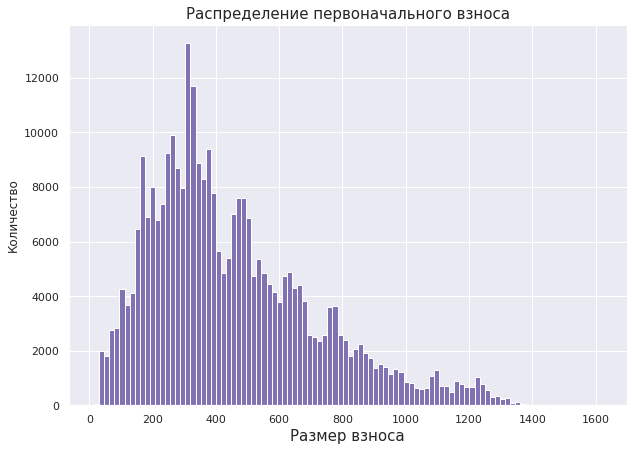

In [ ]:
data['installment'].hist(bins=100, facecolor='m', figsize=(10, 7))
plt.title('Распределение первоначального взноса', size = 15)
plt.xlabel('Размер взноса', size = 15)
plt.ylabel('Количество', size = 12)

plt.show()

Сильных каких-то выбросов нет, поэтому думаю тут ничего делать не нужно.

Риск дефолта или очень поздного погашения в зависимости от опыта работы:

In [ ]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Default', 'In Grace Period',
       'Late (16-30 days)', 'Late (31-120 days)'], dtype=object)

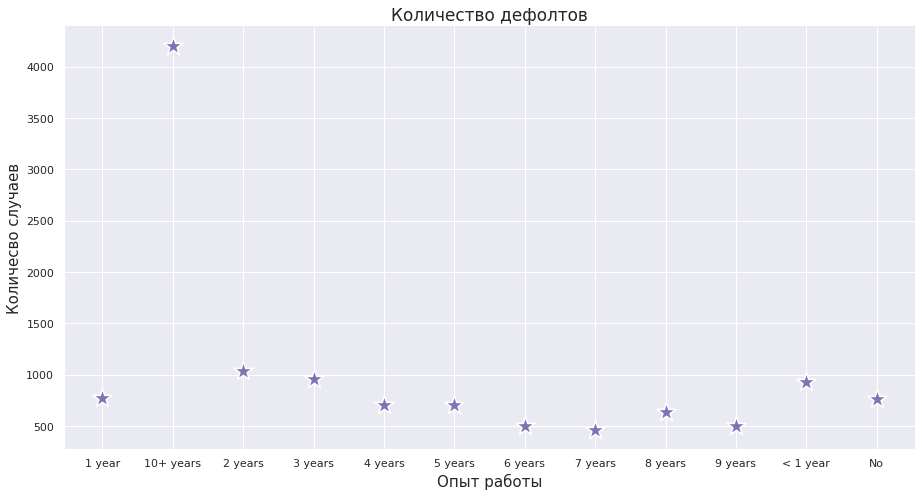

In [ ]:
answ = data.loc[(data['loan_status'] == 'Default') | (data['loan_status'] == 'Late (31-120 days)')]

ax = sns.relplot(data = answ.groupby('emp_length').count()['loan_status'], marker="*", color="m", s = 400)

plt.title('Количество дефолтов', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Количесво случаев', size = 15)
ax.fig.set_size_inches(15, 7)

Здесь какая-то очень странная зависимость, но я предполагаю что это потому что людей с опытом 10+ лет просто больше всего, поэтому больше всего и случаев.

In [ ]:
data['emp_title'].value_counts()

                                            29481
Teacher                                      5667
Manager                                      4927
Owner                                        2697
Registered Nurse                             2429
                                            ...  
Sr. Manager Legal Operations                    1
SHOP COORDINATOR                                1
Program Administrative Supervisor               1
Food and beverage Director                      1
Coordinator for Assessment, Research, an        1
Name: emp_title, Length: 91542, dtype: int64

Честно говоря не знаю, что можно вообще сделать с профессиями, потому что кажется что у них очень неравномерное рапределение и оно почти никак не зависит.

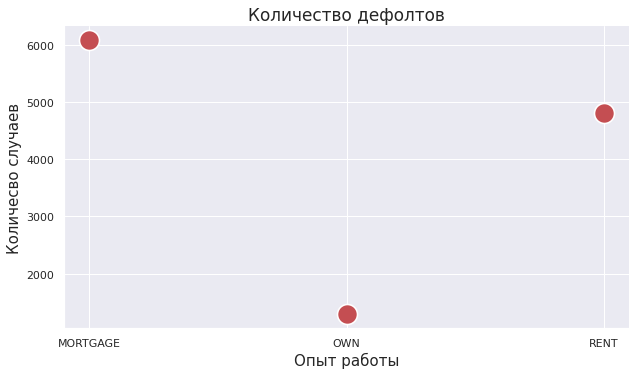

In [ ]:
answ = data.loc[(data['loan_status'] == 'Default') | (data['loan_status'] == 'Late (31-120 days)')]

ax = sns.relplot(data = answ.groupby('home_ownership').count()['loan_status'], color="r", s = 400)

plt.title('Количество дефолтов', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Количесво случаев', size = 15)
ax.fig.set_size_inches(10, 5)

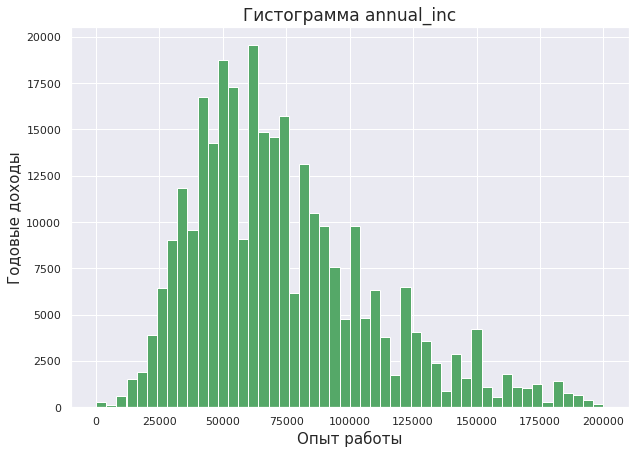

In [ ]:
plt.ticklabel_format(style='plain')
data[data['annual_inc'] < 200000]['annual_inc'].hist(bins=50, color='g', figsize=(10, 7))

plt.title('Гистограмма annual_inc', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Годовые доходы', size = 15)
plt.show()

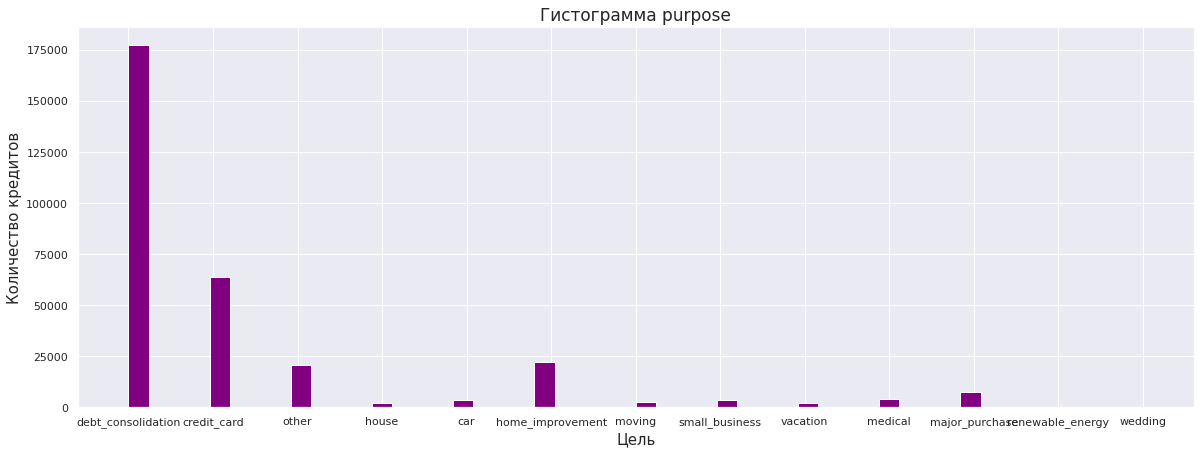

In [ ]:
plt.ticklabel_format(style='plain')
data['purpose'].hist(bins=50, color='purple', figsize=(20, 7))

plt.title('Гистограмма purpose', size = 17)
plt.xlabel('Цель', size = 15)
plt.ylabel('Количество кредитов', size = 15)
plt.show()

In [ ]:
data['purpose'].value_counts()

debt_consolidation    177494
credit_card            64011
home_improvement       22231
other                  20933
major_purchase          7630
medical                 4067
small_business          3501
car                     3445
moving                  2448
vacation                2293
house                   2181
renewable_energy         213
wedding                    2
Name: purpose, dtype: int64

блин реально столько людей берут в долг чтобы погашать другие долги...

## Ridge-регрессия с параметрами по умолчанию


Закодируем через OneHot все категориальные и отмасштабируем часть численных:

In [ ]:
data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,...,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,loan_status,risk
0,1,2500,2500,2500.0,36,13.56,84.92,C,Chef,10+ years,...,2018-12-01,0.0,11,15603,37.0,19,0.0,30026.442500,Fully Paid,0
1,2,30000,30000,30000.0,60,18.94,777.23,D,Postmaster,10+ years,...,2018-12-01,0.0,18,34971,64.5,37,0.0,40856.678960,Fully Paid,0
2,3,5000,5000,5000.0,36,17.97,180.69,D,Administrative,6 years,...,2018-12-01,0.0,9,25416,29.9,19,0.0,20215.792430,Fully Paid,0
3,4,4000,4000,4000.0,36,18.94,146.51,D,IT Supervisor,10+ years,...,2018-12-01,0.0,12,4472,15.3,25,0.0,4549.217149,Fully Paid,0
4,5,30000,30000,30000.0,60,16.14,731.78,C,Mechanic,10+ years,...,2018-12-01,0.0,21,36812,65.7,37,0.0,8735.148975,Fully Paid,0


In [ ]:
categorical = ['emp_title', 'home_ownership', 'verification_status', 'emp_length']
numeric_features = ['loan_amnt', 'installment']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [ ]:
x = data.drop(columns = ['risk'])
y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [ ]:
model = pipeline.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE = 0.3992
Test RMSE = 0.4693


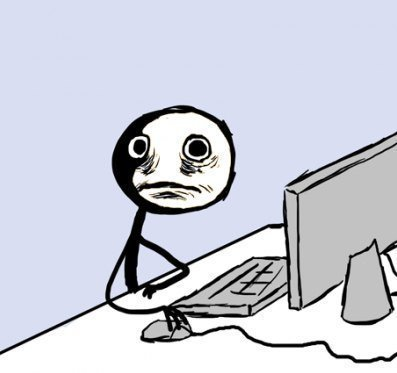